# NS-kernel GP

In this notebook I will take a random sample of points from the SVG smoothed signal (created in Sunspot Data Plotting) and see if the Gaussian process can (essentially) fill in the rest of the points.

For this I will be using the ***non-stationary neural network kernel function***, multiplied by the periodic kernel, given by:

$$ NSNN(x,z) = \exp \left( -\frac{1}{2} \sum_{i=1}^{d} \left( \frac{x_i - z_i}{l_i} \right)^2 \right) $$


A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt

In [2]:
df = pd.read_csv('../../../Data/Savitzky-Golay Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values

In [3]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return tt.log(self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset)

In [4]:
class NonStationaryNNKernel(pm.gp.cov.Covariance):
    def __init__(self, input_dim, sf, ls):
        self.input_dim = input_dim
        self.sf = sf
        self.ls = ls

    def square_dist(self, X, Z):
        X = tt.reshape(X, (-1, 1, X.shape[1]))
        Z = tt.reshape(Z, (1, -1, Z.shape[1]))
        # Scale the input dimensions using the length scales
        X = X / self.ls
        Z = Z / self.ls
        return tt.sum(tt.sqr(X - Z), axis=-1)

    def __call__(self, X, Z=None, diag=False):
        Z = X if Z is None else Z
        if diag:
            return tt.zeros((X.shape[0],))
        r2 = self.square_dist(X, Z)
        return self.sf**2 * tt.exp(-r2 / 2)


## Data Preprocessing

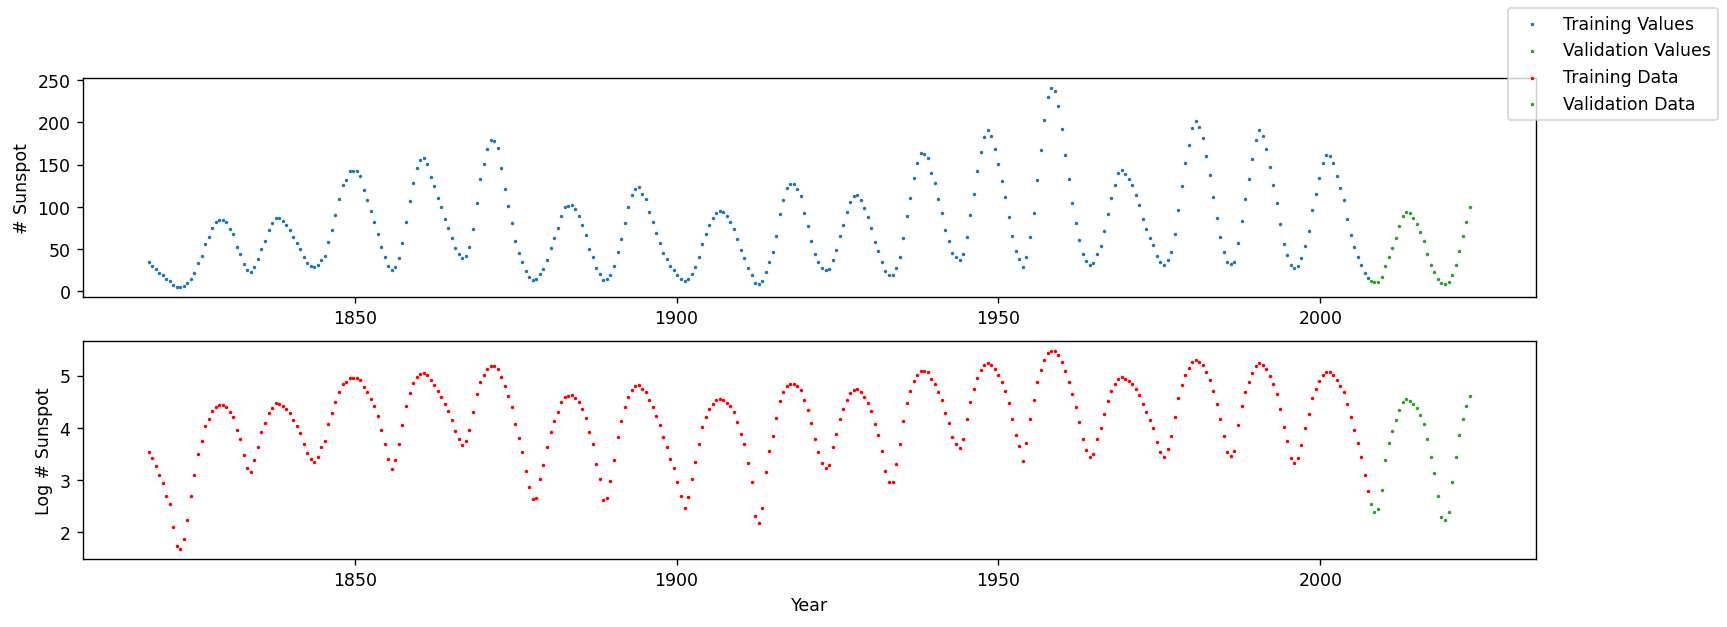

In [5]:
limit = int(0.925*len(X)) # end point of full data when training
skips = 200 # number of points skipped

train_data = df.iloc[:limit:skips] 
validation_data = df.iloc[limit::skips]

training_values = (train_data.Year.values).reshape(-1,1), train_data.Sunspot_Number.values
validation_values = (validation_data.Year.values).reshape(-1,1), validation_data.Sunspot_Number.values

training_data = training_values[0], np.log(training_values[1]) 
validation_data = validation_values[0], np.log(validation_values[1])

# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].scatter(validation_values[0], validation_values[1], label='Validation Values', s=1, color='tab:green')
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].scatter(validation_data[0], validation_data[1], label='Validation Data', s=1, color='tab:green')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

In [6]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)
input_dim = 1

with pm.Model() as model:
    # Define the NN hyperparameters
    ls1 = pm.Uniform("ls1", 0, 20)
    
    sf = pm.Uniform("sf", 0, 5)
    
    # Define the phase of the sinusoidal mean
    phase = pm.Uniform('phase', 0, 5) 
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Uniform('amplitude', 0, 200) 
     
    # Define the offset of the sinusoidal mean
    offset = pm.Uniform('offset', 0, 100) 
    
    # Define the `Period' 
    period = pm.Uniform('period', 10, 12)
    
    # Define the `length scale 1' of the periodic kernel
    ls2 = pm.Uniform('ls2', 0, 5)  
    
    # Define the `Standard deviation' 
    sigma = pm.Normal('$\sigma$', 0.1, 0.05)

    # Create the non-stationary neural network kernel
    non_stationary_kernel = NonStationaryNNKernel(input_dim, ls=ls1, sf=sf)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=ls2)
    
    # Define product of kernels
    kernel = non_stationary_kernel * cov_periodic
    
    # Define Mean Function
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    # Create the Gaussian Process using the kernel
    gp = pm.gp.Marginal(cov_func=kernel, mean_func=sinusoidal_mean)

    # Add Gaussian noise to the likelihood
    #noise = pm.HalfCauchy("noise", beta=5)
    y_obs = gp.marginal_likelihood("y_obs", X=X_train, y=y_train, noise=sigma)

    # Sample from the posterior distribution
    tr = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, ls2, period, offset, amplitude, phase, sf, ls1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22769 seconds.
The acceptance probability does not match the target. It is 0.6588878260268924, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47114013221487916, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


The above code required a lot of trial and error to see at which points the priors converge to their optimal values, and continued readjustment of priors eventually lead to the values we have below.

**Update:** I have created a custom mean function using *theano*. This mean function is sinusoidal, as opposed to the constant one which was being used previously. I have done this because I don't want my GP to tend to a constand value when it gets too far from the previous data point, as we expect the solar cycle to retain its general sinusoidal shape.

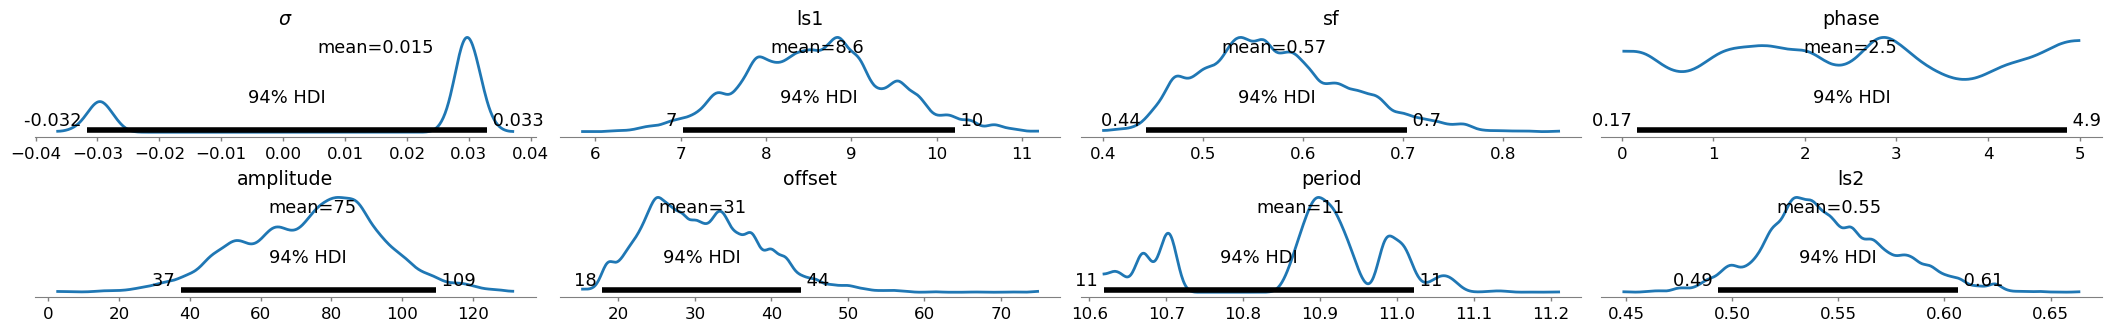

In [7]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12);
#plt.savefig('gp post.png'); 

#### Comment on plot:

For the latest run-through I have set a separate parameter for the period of the sinusoidal mean (as opposed to the 11 year period previously attempted). As we can see from the posteriors, this parameter has 'messed up' the smooth distributions we had before, and the value for period has many different peaks. 

I still believe that the correct period in the sinusoidal mean should be ~ 11 years, but for the posterior of *period1* shows something very different and needs exploring further.

In [8]:
X_new = validation_data[0]
with model:
    fnew = gp.conditional("f_taylor1", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_taylor1"])#

/Applications/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


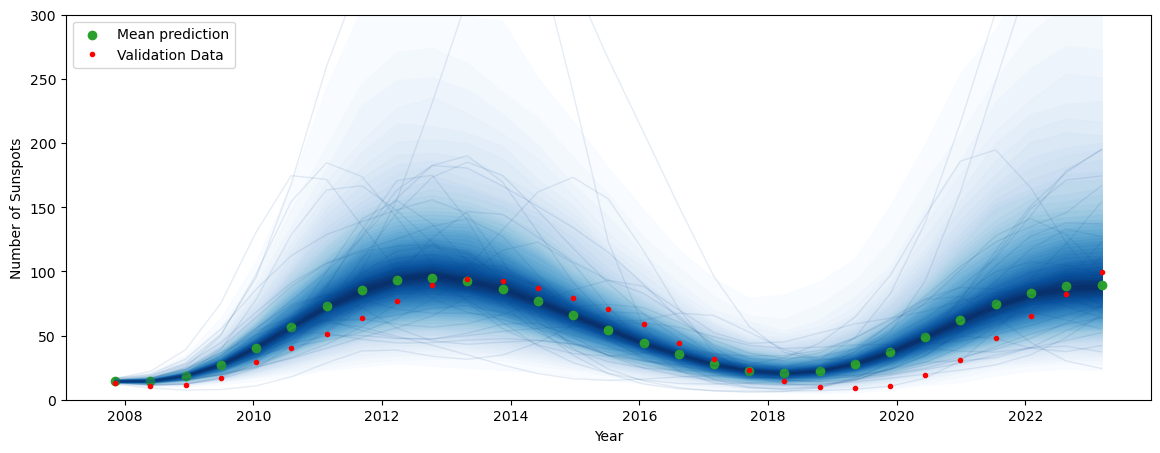

In [9]:
from pymc3.gp.util import plot_gp_dist

# Sampling predictions
mu = np.exp(np.mean(ppc['f_taylor1'], axis=0))
std = np.exp(np.std(ppc['f_taylor1'], axis=0))

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_taylor1']), X_new, palette="Blues")
# np.exp() to return log value to normal value

plt.scatter(X_new, mu, color = 'tab:green', label='Mean prediction')
# plot original data and GP
plt.plot(validation_data[0], np.exp(validation_data[1]), "or", ms=3, alpha=1.0, label="Validation Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
#plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

In [10]:
import csv

# Calculating MSE and MAE
mse = np.mean((mu - np.exp(validation_data[1]))**2)
mae = np.mean(np.abs(mu - np.exp(validation_data[1])))

print("MSE: ", mse)
print("MAE: ", mae)

# Saving MSE and MAE to CSV
with open('Metrics/Split 1/NS_kernel_errors.csv', mode='w') as csv_file:
    fieldnames = ['Metric', 'Value']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerow({'Metric': 'MSE', 'Value': mse})
    writer.writerow({'Metric': 'MAE', 'Value': mae})

MSE:  238.26702190476948
MAE:  12.96981531616954


In [11]:
X_new = np.linspace(1818, 2023, 1000)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"]);

/Applications/anaconda3/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [12]:
# create a dataframe from the posterior predictive samples
df = pd.DataFrame(np.exp(ppc["f_new"]), index=X_new.flatten())

# save the dataframe to a CSV file
df.to_csv("GP Model Data/Split 1/NS_kernel.csv")